# Assignment: Running a K-Means Cluster Analysis

## Assignment 4 of Machine Learning for Data Analysis

## Summary

A k-means cluster analysis was conducted to identify the underlying subgroups of drug status based on 8 variables that represent characteristics that could have an impact on drug usage. Clustering variables included White ethnicity, parents split, age at split, which parent remained, highest grade achieved, the persons job industry, job type and employer type. All clustering variables were standardized to have a mean of 0 and a standard deviation of 1.

Data were randomly split into a training set that included 70% of the observations (N=4141) and a test set that included 30% fo the observations (N=1775).

<img src="KmeansElbow.png" />

The elbow curve was inconclusive and a 4 cluster model was selected for the analysis. 

Canonical discriminant analyses was used to reduce the 8 clustering variable down a few variables that accounted for most of the variance in the clustering variables. A scatterplot of the first four canonical variables by cluster (Figure 2 shown below) indicated that the observations in clusters 1 to 4 were densely packed with relatively low within cluster variance, and little overlap with the other clusters.

<img src="Kmeans.png" />

The means on the clustering variables showed that, compared to the other clusters, drug status in cluster 3 had high levels on the clustering variables white ethnicity but low levels on the rest. In cluster 4 the age at which parents split and white ethnicity had very high levels, which parent remained variable had a moderate level and the rest low. For clusters 1 and 2 the variables had very low levels.

In order to externally validate the clusters, an Analysis of Variance (ANOVA) was conducting to test for significant differences between the clusters on drug status. A tukey test was used for post hoc comparisons between the clusters. The cluster means of clusters 1 and 2 were not significantly different and likewise for clusters 3 and 4. Individuals in clusters 3 and 4 had the highest likelihood of drug usage, and cluster 3 had the lowest likelihood of drug usage.

## Python Code

In [1]:
%matplotlib inline
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

Import the data and set the column names.

In [2]:
nesarc_data = pd.read_csv("https://dl.dropboxusercontent.com/u/84673878/nesarc_output_cut.csv")
cols = ["WHITE","PARENTS_SPLIT","SPLIT_AGE","WHICH_PARENT_REMAINED","HIGHEST_GRADE",
        "JOB_INDUSTRY","JOB_TYPE","EMPLOYER_TYPE","DGSTATUS"]
nesarc_data.columns = cols

Convert each column to numeric so that we can apply NaN to all missing values using the errors='coerce' argument, which will make it easier to drop the NaNs.

In [3]:
nesarc_data = nesarc_data.apply(lambda x: pd.to_numeric(x,errors='coerce'))

Check the data types

In [4]:
nesarc_data.dtypes

WHITE                      int64
PARENTS_SPLIT              int64
SPLIT_AGE                float64
WHICH_PARENT_REMAINED    float64
HIGHEST_GRADE              int64
JOB_INDUSTRY             float64
JOB_TYPE                 float64
EMPLOYER_TYPE            float64
DGSTATUS                   int64
dtype: object

Remove the NaNs

In [5]:
nesarc_data = nesarc_data.dropna()

Convert the target to a binary variable, 0 = never used drugs, 1 = current or past drug user

In [6]:
row_index = nesarc_data.DGSTATUS == 3
nesarc_data.loc[row_index, 'DGSTATUS'] = 0
row_index = nesarc_data.DGSTATUS == 2
nesarc_data.loc[row_index, 'DGSTATUS'] = 1

Subset clustering variables

In [7]:
cluster = nesarc_data[["WHITE","PARENTS_SPLIT","SPLIT_AGE","WHICH_PARENT_REMAINED",
                          "HIGHEST_GRADE","JOB_INDUSTRY","JOB_TYPE","EMPLOYER_TYPE"]]
dgstatus = nesarc_data['DGSTATUS']

Using a lambda expression convert to float and scale each feature in the data frame

In [8]:
cluster = cluster.apply(lambda x: preprocessing.scale(x.astype('float64')))

Split the data into train and test sets

In [9]:
clus_train, clus_test = train_test_split(cluster, test_size=.3, random_state=123)

K-Means cluster analysis for 1-9 clusters 

In [10]:
from scipy.spatial.distance import cdist
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])

Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose

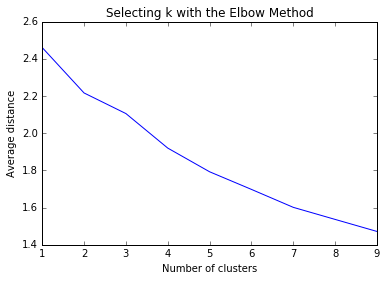

In [11]:
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

Interpret 4 cluster solution

In [12]:
kmodel=KMeans(n_clusters=4)
kmodel.fit(clus_train)
clusassign=kmodel.predict(clus_train)

Plot clusters

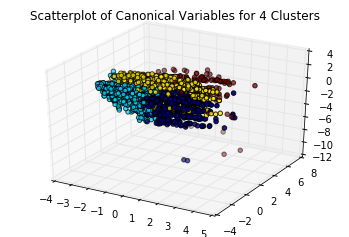

In [14]:
from sklearn.decomposition import PCA
pca_3 = PCA(3)
plot_columns = pca_3.fit_transform(clus_train)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=plot_columns[:,0], ys=plot_columns[:,1], zs=plot_columns[:,2],c=kmodel.labels_,)
plt.title('Scatterplot of Canonical Variables for 4 Clusters')
plt.show()

BEGIN multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
Create a unique identifier variable from the index for the 
Cluster training data to merge with the cluster assignment variable

In [15]:
clus_train.reset_index(level=0, inplace=True)
cluslist=list(clus_train['index'])
labels=list(kmodel.labels_)
newlist=dict(zip(cluslist, labels))
newclus=DataFrame.from_dict(newlist, orient='index')
newclus.columns = ['cluster']
newclus.reset_index(level=0, inplace=True)
merged_train=pd.merge(clus_train, newclus, on='index')

END multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster

In [16]:
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
                index     WHITE  PARENTS_SPLIT  SPLIT_AGE  \
cluster                                                     
0        17935.312917 -0.585164            0.0  -0.165936   
1        18648.313094 -0.579288            0.0  -0.149855   
2        19089.041502  1.696863            0.0  -0.162046   
3        21099.681416  0.806667            0.0   5.731927   

         WHICH_PARENT_REMAINED  HIGHEST_GRADE  JOB_INDUSTRY  JOB_TYPE  \
cluster                                                                 
0                     0.139442      -0.503319     -0.640098  0.430316   
1                    -0.106780       0.684692      0.718410 -0.572250   
2                    -0.092088      -0.054507      0.111234  0.061910   
3                     0.384805      -0.128089     -0.063650  0.148696   

         EMPLOYER_TYPE  
cluster                 
0            -0.288972  
1             0.371137  
2             0.031486  
3             0.003194  


Validate clusters in training data by examining cluster differences in GPA using ANOVA
First we have to merge GPA with clustering variables and cluster assignment data 

In [17]:
# split DGStatus data into train and test sets
dg_train, dg_test = train_test_split(dgstatus, test_size=.3, random_state=123)
dg_train1=pd.DataFrame(dg_train)
dg_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(dg_train1, merged_train, on='index')
sub1 = merged_train_all[['DGSTATUS', 'cluster']].dropna()

In [18]:
gpamod = smf.ols(formula='DGSTATUS ~ C(cluster)', data=sub1).fit()
print (gpamod.summary())

                            OLS Regression Results                            
Dep. Variable:               DGSTATUS   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     19.43
Date:                Sun, 10 Jul 2016   Prob (F-statistic):           1.66e-12
Time:                        20:51:43   Log-Likelihood:                -2773.0
No. Observations:                4141   AIC:                             5554.
Df Residuals:                    4137   BIC:                             5579.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.3918      0.012     

In [19]:
print ('means for DGStatus by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)

means for DGStatus by cluster
         DGSTATUS
cluster          
0        0.391753
1        0.366496
2        0.262846
3        0.212389


In [20]:
print ('standard deviations for DGStaus by cluster')
m2= sub1.groupby('cluster').std()
print (m2)

standard deviations for DGStaus by cluster
         DGSTATUS
cluster          
0        0.488290
1        0.482023
2        0.440397
3        0.410821


In [21]:
mc1 = multi.MultiComparison(sub1['DGSTATUS'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.0253  -0.0697  0.0192 False 
  0      2    -0.1289  -0.1774 -0.0804  True 
  0      3    -0.1794  -0.2976 -0.0612  True 
  1      2    -0.1037  -0.1541 -0.0532  True 
  1      3    -0.1541  -0.2731 -0.0351  True 
  2      3    -0.0505   -0.171  0.0701 False 
---------------------------------------------
